In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
plt.style.use('fivethirtyeight')
import tensorflow as tf


In [4]:
df = pd.read_csv('bitstampUSD.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
df.drop('Timestamp',axis=1,inplace=True)
df.dropna(axis=0,inplace=True)
df.shape

(1262908, 8)

In [6]:
subSet = df.groupby('date')
Real_Price = subSet['Weighted_Price'].mean()
Real_Price.shape

(1597,)

In [7]:
prediction_days = 30
df_test= Real_Price[len(Real_Price)-prediction_days:]
df_train= Real_Price[:len(Real_Price)-prediction_days]

In [8]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
X_train.shape

(1566, 1, 1)

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)
model = Sequential()
model.add(LSTM(units = 40, activation = 'sigmoid',return_sequences = True,input_shape = (None, 1)))
model.add(LSTM(units = 60, activation = 'sigmoid',return_sequences = False))
model.add(Dense(units = 128,activation = 'relu'))
model.add(Dense(units = 52,activation = 'relu'))
model.add(Dense(units = 28,activation = 'relu'))
model.add(Dense(units = 1,activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')



In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 40)          6720      
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                24240     
_________________________________________________________________
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
dense_1 (Dense)              (None, 52)                6708      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1484      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 29        
Total params: 46,989
Trainable params: 46,989
Non-trainable params: 0
__________________________________________________

In [13]:
history = model.fit(X_train, y_train, batch_size = 5, epochs = 50,validation_data=(X_val,y_val))

Epoch 1/50
201/201 [==============================] - 3s 5ms/step - loss: 0.0649 - val_loss: 0.0430
Epoch 2/50
201/201 [==============================] - 1s 3ms/step - loss: 0.0413 - val_loss: 0.0433
Epoch 3/50
201/201 [==============================] - 1s 3ms/step - loss: 0.0402 - val_loss: 0.0410
Epoch 4/50
201/201 [==============================] - 1s 3ms/step - loss: 0.0406 - val_loss: 0.0382
Epoch 5/50
201/201 [==============================] - 1s 3ms/step - loss: 0.0352 - val_loss: 0.0073
Epoch 6/50
201/201 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 8.2505e-04
Epoch 7/50
201/201 [==============================] - 1s 3ms/step - loss: 7.4344e-04 - val_loss: 5.9681e-04
Epoch 8/50
201/201 [==============================] - 1s 3ms/step - loss: 5.4536e-04 - val_loss: 5.7870e-04
Epoch 9/50
201/201 [==============================] - 1s 3ms/step - loss: 6.0025e-04 - val_loss: 4.9381e-04
Epoch 10/50
201/201 [==============================] - 1s 3ms/step - los

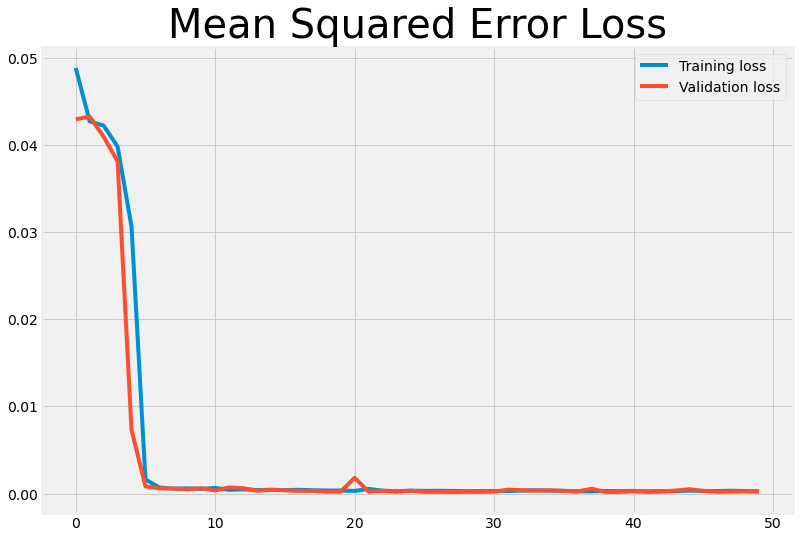

In [17]:
epochs = np.arange(0,50)
plt.figure(figsize=(12,8), facecolor='w', edgecolor='k')
plt.title('Mean Squared Error Loss', fontsize = 40)
plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.legend()


In [18]:
test_set = df_test.values[1:]
sc = MinMaxScaler()
inputs = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
inputs = sc.fit_transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))


In [19]:
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

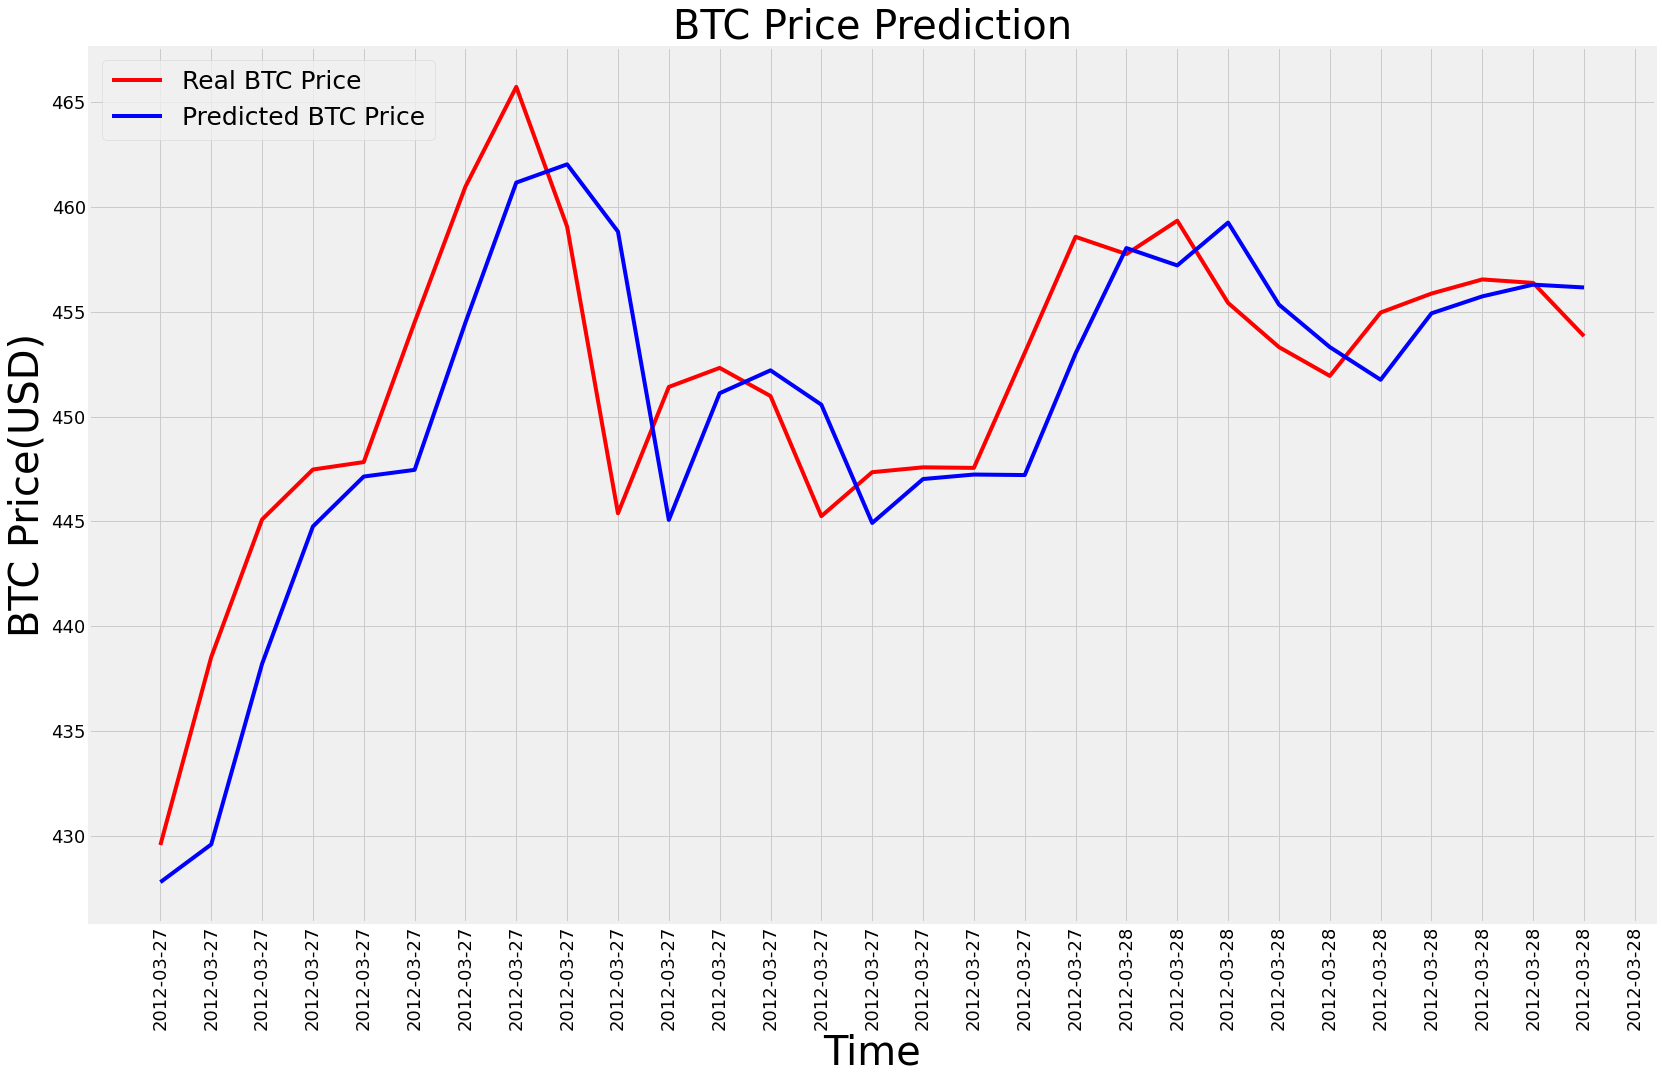

In [20]:
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x = df_test.index
labels = df['date'][len(Real_Price)-prediction_days:]
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()